In [1]:
import os
import gdown
import zipfile
import numpy as np
import pandas as pd

In [2]:
project_path = os.path.dirname(os.getcwd())
data_path = os.path.join(project_path, "data")

To run this notebook put unarchived [Amazon Reviews 2018 (Full Dataset)](https://www.kaggle.com/datasets/rogate16/amazon-reviews-2018-full-dataset?resource=download) in `data` directory  
OR  
Uncomment and run the following two cells

In [3]:
# file_id = "1gyMc40KnAqzMkAVjuYTOFq4q0JgFSk11"
# output = os.path.join(data_path, "amazon_reviews.zip")
# gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1gyMc40KnAqzMkAVjuYTOFq4q0JgFSk11
From (redirected): https://drive.google.com/uc?id=1gyMc40KnAqzMkAVjuYTOFq4q0JgFSk11&confirm=t&uuid=7ffcc9e1-cb07-4a13-8a78-927472f54be3
To: /Users/oleg/INSAIT/assignment/data/amazon_reviews.zip
100%|██████████| 368M/368M [00:05<00:00, 65.6MB/s] 


'/Users/oleg/INSAIT/assignment/data/amazon_reviews.zip'

In [4]:
# with zipfile.ZipFile(output, "r") as zip_ref:
#     zip_ref.extractall(data_path)

In [ ]:
df = pd.read_csv(os.path.join(data_path, "amazon_reviews.csv"))

In [3]:
df.shape

(551159, 14)

In [4]:
df.head()

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0
2,Jaclyn,True,"Pet Champion Adjustable No-Pull Harness, Colla...","[""The Pet Champion Large/ Extra Large 22-36 in...",['https://images-na.ssl-images-amazon.com/imag...,Pet Champion,"['Features Bright Pink Lemonade pattern', 'Dua...",Pet_Supplies,$7.99,5.0,2018-01-01,she has an odd shape chest and her pull over h...,Finally a harness that fits my puppy. I really...,0
3,Christinne M,False,Koh-I-Noor Progresso Woodless Colored 24-Penci...,['Koh-I-Noor Progresso Woodless Colored 24-Pen...,['https://images-na.ssl-images-amazon.com/imag...,KOH-I-NOOR,"['Rich, pigmented, solid color encased in lacq...",Arts_Crafts_and_Sewing,$14.18,5.0,2018-01-01,Loving!!,I LOVE THEM!! I bought them at Micheals our of...,0
4,Sandy,True,"Parker Urban Premium Ebony Metal Chiseled, Bal...","[""Stunning craftsmanship based on a classic st...",['https://images-na.ssl-images-amazon.com/imag...,Parker,['Ebony black with metallic highlights and a g...,Office_Products,NaN,5.0,2018-01-01,I love this pen,"I love this pen! I love the shape of it, the f...",0


The task is to build recommendation system that given a customer ID returns top 5 personalized products.
The ID columns for the case will be: **userName** - to be able to identify the customers, and **itemName** - to identify the items  


In this assigmnent I will not use **image** column because the checked images have poor quality and thir usage will significantly complicate the analysis

In [5]:
df.drop(columns=["image"], inplace=True)

Now I am going to transform columns that contain textual information. I will first remove all the HTML tags (if there are any), then make everything lowercase, and, finally, remove all the punctuation. I will keep the numbers on this step because there can be similar products with different weight / size.

In [6]:
for col in ["itemName", "description", "brand", "feature", "category", "summary", "reviewText"]:
    df[col] = df[col].replace(to_replace=r"<.*?>", value="", regex=True)\
        .str.lower().replace(to_replace=r"[^\w\s]", value="", regex=True).str.strip()

In [7]:
print("Number of duplicated rows in the dataset:", df.duplicated().sum())

Number of duplicated rows in the dataset: 41103


In [8]:
# Drop the duplicated rows
df.drop_duplicates(keep="first", inplace=True)

In [9]:
df.shape

(510056, 13)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510056 entries, 0 to 551158
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userName     509929 non-null  object 
 1   verified     510056 non-null  bool   
 2   itemName     510055 non-null  object 
 3   description  510050 non-null  object 
 4   brand        506844 non-null  object 
 5   feature      510056 non-null  object 
 6   category     510056 non-null  object 
 7   price        440436 non-null  object 
 8   rating       510056 non-null  float64
 9   reviewTime   510056 non-null  object 
 10  summary      509819 non-null  object 
 11  reviewText   509659 non-null  object 
 12  vote         510056 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 51.1+ MB


In [11]:
price_no_nan = df.dropna(subset="price")["price"]
price_length = price_no_nan.apply(len)
print("Different types of information in 'price column:\n")
print("short length values (<= 7):", price_no_nan[(price_length <= 7)].iloc[0])
print("medium length values (> 7, <= 9):", price_no_nan[(price_length > 7) & (price_length <= 9)].iloc[0])
print("high length values (> 9, <= 15):", price_no_nan[(price_length > 9) & (price_length <= 15)].iloc[0])
print("extremely high length values (>= 15):", price_no_nan[(price_length >= 15)].iloc[0])

print("additional concern - $0.00 price:", (price_no_nan == "$0.00").sum())

Different types of information in 'price column:

short length values (<= 7): $1.63
medium length values (> 7, <= 9): $1,129.96
high length values (> 9, <= 15): $8.34 - $249.88
extremely high length values (>= 15): .a-box-inner{background-color:#fff}#alohaBuyBoxWidget .selected{background-color:#fffbf3;border-color:#e77600;box-shadow:0 0 3px rgba(228,121,17,.5)}#alohaBuyBoxWidget .contract-not-available{color:gray}#aloha-cart-popover .aloha-cart{height:auto;overflow:hidden}#aloha-cart-popover #aloha-cartInfo{float:left}#aloha-cart-popover #aloha-cart-details{float:right;margin-top:1em}#aloha-cart-popover .deviceContainer{width:160px;float:left;padding-right:10px;border-right:1px solid #ddd}#aloha-cart-popover li:last-child{border-right:0}#aloha-cart-popover .aloha-device-title{height:3em;overflow:hidden}#aloha-cart-popover .aloha-thumbnail-container{height:100px;margin-bottom:1em;text-align:center}#aloha-cart-popover .aloha-price-container{text-align:center}#aloha-cart-popover .aloha-t

The price data is not clear and is not unified. There are single prices as well as ranges, and HTML/CSS patterns.  
The first problem is ranges, which should be checked against the business and a way to resolve it must be discussed. For the assignment I will apply 'mean' transformation to the range boudaries.  
The second is HTML/CSS patterns, which probably the result of the parsing error. This must be fixed during the data collection step. There is no direct way to deal with such cases, so this type of data I will consider as missing.  
Additionsl problem is "zero price". In general these cases should be checked against the business as well, but for the assignment having that there are only 10 such cases I will consider this as "no-data".  
To fix data in column "price" I will first extract all the accurances that matches the pattern: "$x(xx,xxx,xxx).xx". In case there is a range provided I will apply 'mean' function and NaN values will be assigned if no pattern found.

In [12]:
# fixing columns "price"
df["price"] = df["price"].str.extractall(r"\$ ?(\d{1,3}(?:,\d{3})*\.\d{2})")\
    .replace({r"\$": "", ",": ""}, regex=True)[0].astype(float)\
    .groupby(level=0).agg("mean").reindex(df.index, fill_value=np.nan)

In [13]:
df["price"].describe()

count    428487.00000
mean         20.84884
std          37.48667
min           0.00000
25%           7.99000
50%          12.99000
75%          22.20000
max        7514.19000
Name: price, dtype: float64

The question to raise is why there are prices equal to zero?

Now I want to check how unique "itemName" column is: are there identical items with different description or with different brand names, etc.

In [14]:
# Ensuring that every item has only one usinque match in desctiptive columns:
for col in ["description", "brand", "feature", "category", "price"]:
    non_unique = sum(df.groupby("itemName")[col].nunique(dropna=False) > 1)
    group_counts = df.groupby(["itemName", col]).size()
    total_rows = group_counts[group_counts.groupby(level=0).transform("size") > 1].sum()
    print(f"col: {col}, number non unique items: {non_unique}, with total rows: {total_rows}")
print("Total unique items:", df["itemName"].nunique(), "with total rows:", df.shape[0])


col: description, number non unique items: 525, with total rows: 18518
col: brand, number non unique items: 77, with total rows: 1406
col: feature, number non unique items: 548, with total rows: 18972
col: category, number non unique items: 97, with total rows: 1439
col: price, number non unique items: 681, with total rows: 17483
Total unique items: 108972 with total rows: 510056


I assume that different brands can have different descriptions for the same named items:

In [15]:
for col in ["description", "feature", "category", "price"]:
    non_unique = sum(df.groupby(["itemName", "brand"])[col].nunique(dropna=False) > 1)
    group_counts = df.groupby(["itemName", "brand", col]).size()
    total_rows = group_counts[group_counts.groupby(level=[0, 1]).transform("size") > 1].sum()
    print(f"col: {col}, number non unique items: {non_unique}, with total rows: {total_rows}")
print("Total unique brand-items:", df[["itemName", "brand"]].drop_duplicates().shape[0], "with total rows:", df.shape[0])

col: description, number non unique items: 470, with total rows: 17216
col: feature, number non unique items: 503, with total rows: 17884
col: category, number non unique items: 82, with total rows: 1212
col: price, number non unique items: 620, with total rows: 16490
Total unique brand-items: 109128 with total rows: 510056


I see that my assumption was not correct, and the number of rows is relatively high which means they cannot be ignored.  
These cases need more thorough investigation, but for the assignment I will apply the following logic:
- for columns with text like 'description' or 'category' I will reassign values using 'mode'
- for for numeric column (price) I will use 'mean' logic.

In [16]:
def find_mode_mean(group):
    if pd.api.types.is_numeric_dtype(group):
        return group.mean()
    else:
        mode = pd.Series.mode(group, dropna=True)
        
        if not mode.empty:
            return mode[0] 
        else:
            return None


In [17]:
modes_means = df.groupby("itemName")[["description", "brand", "feature", "category", "price"]].agg(find_mode_mean)
modes_means

,description,brand,feature,category,price
itemName,,,,,
0 kraft bubblemailer 150 per case,convenient selfseal closure saves labor and el...,propackagingsupply,each has finned edges for extra edge protectio...,office_products,23.75
0 poly 6x10 bubble mailers envelopes bags bag white 100 count,dimple design for extra toughness,valuemailers,genuine valuemailers trademarked product 64 ...,office_products,19.95
000 4x8quot kraft bubble mailer padded envelopes100 qty,ecolite brand self sealing bubble mailers are ...,bubblepak,value not found,office_products,10.74
0057004 kit primer bulb with 2 feet of each 6617 6616 tygon fuel lines and zf1 fuel filter,can be used on many brands such as poulan weed...,poweka,kit includes the following parts 2 ft of 6616 ...,patio_lawn_and_garden,5.72
007 quantum of solace playstation 3,bond 007 quantum of solace ps3,by\n \n activision,you are the new bond employ all of your bond ...,video_games,NaN
...,...,...,...,...,...
zymox topical pet cream with hydrocortisone 1ounce,zymox topical zymox topical cream provides a p...,pet king brands,provides a powerful natural enzyme formula to ...,pet_supplies,12.99
zymox topical pet spray hydrocortisone 1 infections wound itching dog amp cat 2oz,zymox spray with 1 hydrocortisone offers a pow...,zymox,use zymox spray to treat bacterial fungal or y...,pet_supplies,NaN
zymox topical spray with hydrocortisone,zymox topical spray provides a powerful natura...,zymox,zymox topical spray provides a powerful natura...,pet_supplies,15.98


In [18]:
df_before = df.copy()

In [19]:
for col in ["description", "brand", "feature", "category", "price"]:
    df[col] = df["itemName"].map(modes_means[col])

In [20]:
df.duplicated().sum()

4994

Duplicated rows appeared in the dataframe after imputation i will drop them

In [21]:
df.drop_duplicates(keep="first", inplace=True)
df.shape

(505062, 13)

Now I will check how many rows were affected by the transformation above using pandas.duplicated. I will concatenate a dataframe before the transformation and afret and will check dumber of unique (not duplicated) rows (all the duplicated rows represent unchanged records)

In [22]:
concatenated = pd.concat([df_before, df])
unique_rows = concatenated[~concatenated.duplicated(keep=False)]
print("Number of affected rows:",unique_rows.shape[0] // 2)

Number of affected rows: 160630


The number of affected rows is roughly equal to 10% of all the dataset, so, as I said before this case must be examined more thoroughly

In [23]:
# Ensuring that every item has only one usinque match in desctiptive columns:
for col in ["description", "brand", "feature", "category", "price"]:
    non_unique = sum(df.groupby("itemName")[col].nunique(dropna=False) > 1)
    group_counts = df.groupby(["itemName", col]).size()
    total_rows = group_counts[group_counts.groupby(level=0).transform("size") > 1].sum()
    print(f"col: {col}, number non unique items: {non_unique}, with total rows: {total_rows}")
print("Total unique items:", df["itemName"].nunique(), "with total rows:", df.shape[0])

col: description, number non unique items: 0, with total rows: 0
col: brand, number non unique items: 0, with total rows: 0
col: feature, number non unique items: 0, with total rows: 0
col: category, number non unique items: 0, with total rows: 0
col: price, number non unique items: 0, with total rows: 0
Total unique items: 108972 with total rows: 505062


In [24]:
df.isna().sum()

userName         124
verified           0
itemName           1
description        6
brand           3120
feature            1
category           1
price          79107
rating             0
reviewTime         0
summary          235
reviewText       393
vote               0
dtype: int64

There are two ID columns for the task: userName and itemName.  
The number of missing values in them is low so I will drop these rows.  
Since I am planning to use embedding for the 'description' column and use the results as a product representation, the rows with missing values are also not allowed and will be dropped.  
There is relatively high number of missing values in 'brand' column. I will not use this column, so I will just ignore this, but in the real world scenario the cause of having missing values in columns like 'description', 'brand', 'feature', 'category' must be examined. It is probably due to errorl during data collection.  
There is high number of NaN values in the 'price' column. I believe that this column can be important for the recommendation system and I will apply KNNImputer later on to fill the missing values.  
I will ignore missing values in 'summary' and 'reviewText' for now, since I am not going to use them with my selected approach.

In [25]:
df.loc[df["reviewText"].isna(), "reviewText"] = df.loc[df["reviewText"].isna(), "summary"]

In [26]:
df.drop_duplicates(keep="first", inplace=True)

In [27]:
df.dropna(subset=["userName", "itemName", "description", "reviewText"], how="any", inplace=True)
df.shape

(504875, 13)

In [28]:
df.isna().sum()

userName           0
verified           0
itemName           0
description        0
brand           3117
feature            0
category           0
price          79060
rating             0
reviewTime         0
summary          178
reviewText         0
vote               0
dtype: int64

In [29]:
df.userName.value_counts().head(20)

userName
Amazon Customer    31924
Kindle Customer     2416
Mike                 563
John                 513
Michael              422
David                402
Susan                401
Chris                386
Lisa                 349
Linda                343
Jennifer             339
Mary                 323
Amanda               322
Karen                314
Sarah                310
Debbie               298
Steve                295
James                283
Kim                  282
Barbara              266
Name: count, dtype: int64

1. Queston to the business: are there any unique IDs instead of userName for customers? There are userNames that appear in the dataset hundreds of times (there are hundreds of reviews) during the 10 months of data, which is quite unlikely and needs to be clarified.
2. There are two names (Amazon Customer and Kindle Customer) that represents unknown, unregistered, or casual customers. In my opinion there must be done additional steps to provide personalized recommendations for these customers. Maby the same approach as for "cold start problem" should be used.  
  
For the assignment I will treat customers from these groups as new anknown customers.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

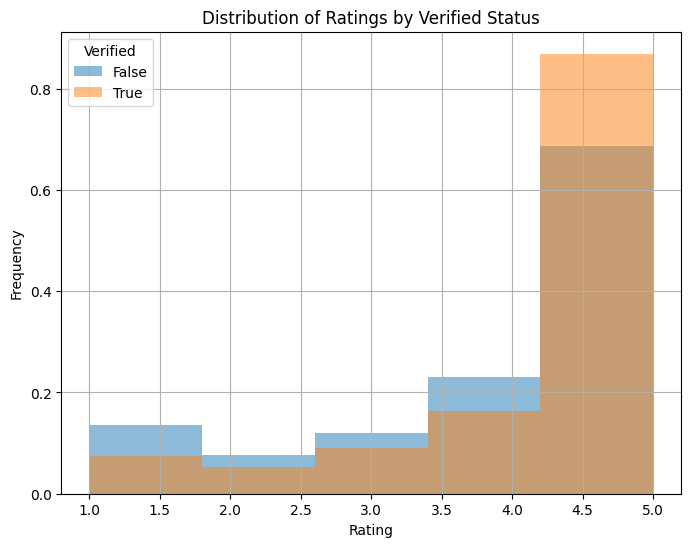

Average Ratings:
verified
False    4.004846
True     4.361781
Name: rating, dtype: float64


In [31]:
grouped_data = df.groupby('verified')
average_ratings = grouped_data['rating'].mean()

plt.figure(figsize=(8, 6))
for verified_status, group in grouped_data:
    plt.hist(group['rating'], density=True, alpha=0.5, label=str(verified_status), bins=5)

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings by Verified Status')
plt.legend(title='Verified')
plt.grid(True)
plt.show()

print("Average Ratings:")
print(average_ratings)

As seen from the distribution above, customers with verified status more often tend to give the highest rating, whereas unverified more often give lower rates. This can be utilized in more comprehensive model / data preporation steps to adjust rating and reduse bias.  
It is also can be used in case when customer profiles created.

In [32]:
df.groupby('category')['price'].describe().sort_values("count", ascending=False)

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
pet_supplies,145537.0,21.400064,26.767571,0.74,8.920000,14.000000,24.9500,1799.99
grocery_and_gourmet_food,74381.0,19.500145,17.891835,0.01,10.900000,14.990000,23.7800,469.97
patio_lawn_and_garden,55344.0,27.521602,57.528203,0.30,8.230000,14.980000,26.9900,2699.00
office_products,48295.0,21.806972,55.454421,0.95,7.095000,11.590000,19.9900,7514.19
cell_phones_and_accessories,33171.0,18.640148,39.029227,0.01,7.980000,10.890000,17.9900,1010.98
arts_crafts_and_sewing,31076.0,14.935092,30.308970,0.01,6.890000,9.605000,14.9500,999.00
prime_pantry,14287.0,4.997200,3.600352,0.50,2.780000,3.890000,5.9900,39.99
musical_instruments,13679.0,19.466516,31.818678,0.00,5.950000,9.970000,19.9500,809.99
industrial_and_scientific,5261.0,22.442442,59.067033,1.35,7.950000,13.190000,19.9900,2125.00


Observations:
- mean price varies significantly across different categories
- some categories have relatively narrow price boudaries, such as 'prime_pantry' (0.50 to 39.99) or 'all_beauty' (4.99 to 23.00), whereas others have wide ranges, such as 'pet_supplies' (0.74 to 1799.99) or 'office_products' (0.95 to 7514.19)
- quartiles analysis shows skewed price distribution and presence of outliers (can show premium products) for majority of categories 

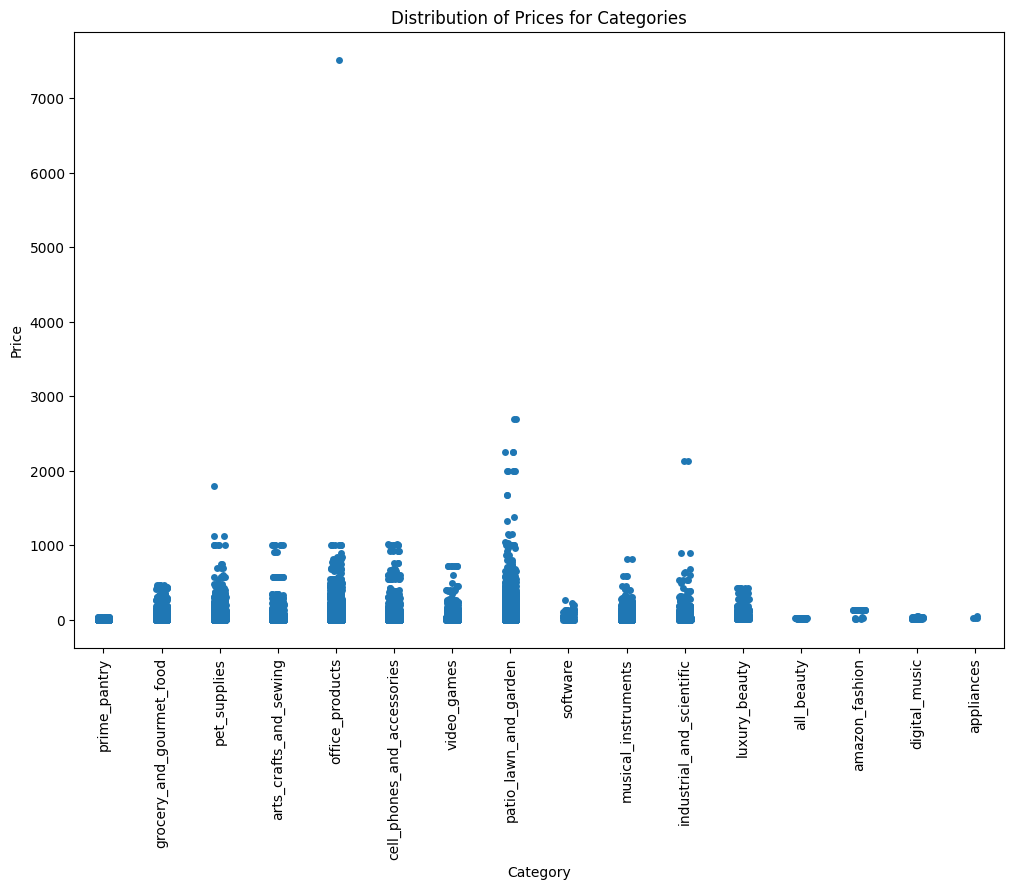

In [33]:
plt.figure(figsize=(12, 8))
sns.stripplot(x='category', y='price', data=df)#[df["price"] < 3000])
plt.xlabel('Category')
plt.ylabel('Price')
plt.title('Distribution of Prices for Categories')
plt.xticks(rotation=90)
plt.show()

There are clear outliers with prices bigger than $1200

In [34]:
len(df[df["price"] < 1200])/len(df.dropna(subset="price"))

0.9999577281213673

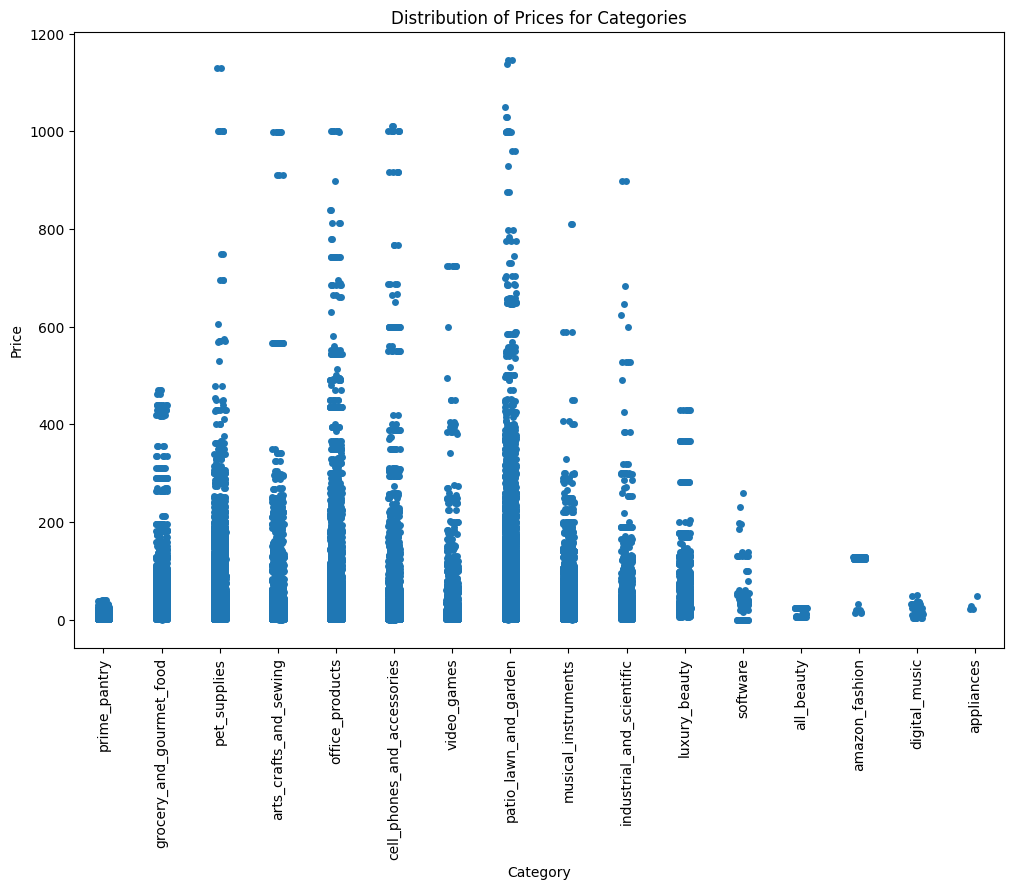

In [35]:
plt.figure(figsize=(12, 8))
sns.stripplot(x='category', y='price', data=df[df["price"] < 1200])
plt.xlabel('Category')
plt.ylabel('Price')
plt.title('Distribution of Prices for Categories')
plt.xticks(rotation=90)
plt.show()

First

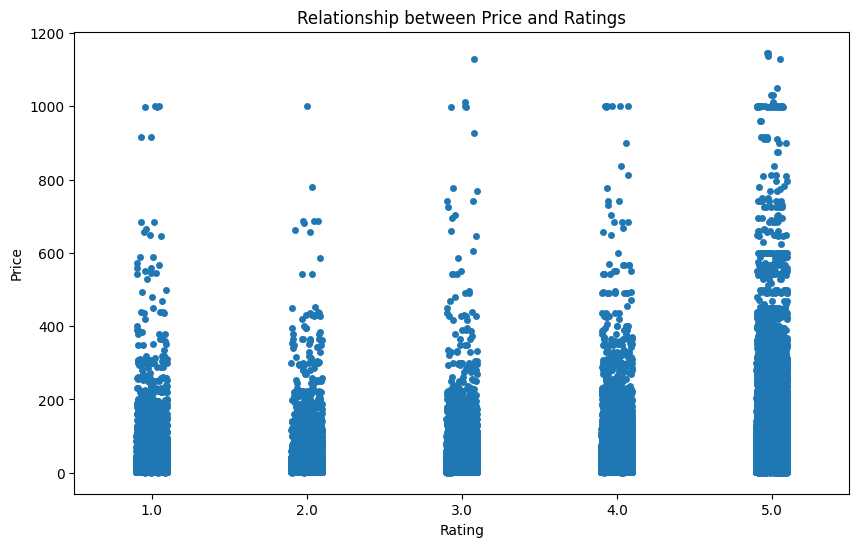

In [36]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='rating', y="price", data=df[df["price"] < 1200])
plt.title('Relationship between Price and Ratings')
plt.xlabel('Rating')
plt.ylabel('Price')
plt.show()

There is a slight correlation berween the price and the rating: for the ratings from 2 to 5 there are more instances with higher prices, but at the same time for the rating 1 there a slight uplift in the number of more expencive items in comparison to rating 2. I assume that higher price elevate negative effect.

In [37]:
reviews_to_rates = df.userName.value_counts().to_frame().merge(
    df.groupby("userName")["rating"].mean().to_frame(), right_index=True, left_index=True
)
reviews_to_rates

,count,rating
userName,,
Amazon Customer,31924,4.408721
Kindle Customer,2416,4.386589
Mike,563,4.349911
John,513,4.237817
Michael,422,4.466825
...,...,...
love,1,1.000000
sheng,1,5.000000
TooToot,1,5.000000


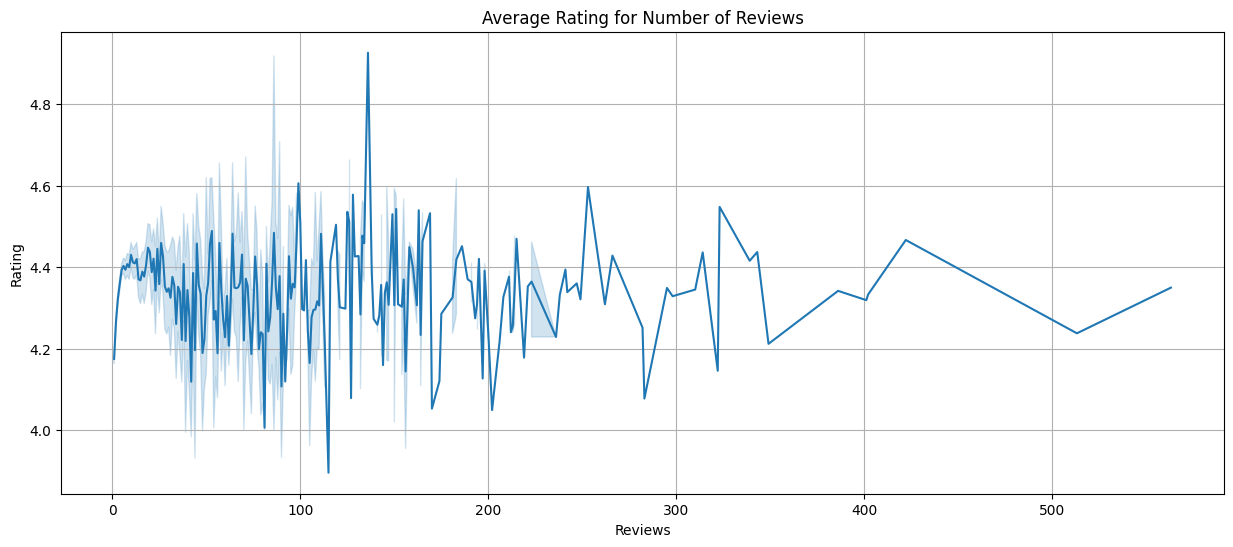

In [38]:
plt.figure(figsize=(15, 6))
sns.lineplot(x="count", y='rating', data= reviews_to_rates[reviews_to_rates["count"] < 1000])
plt.title('Average Rating for Number of Reviews')
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

There is no direct correlation between the number of reviews customers have and the average rating they gave.

In [39]:
df["reviewLength"] = df["reviewText"].str.len()

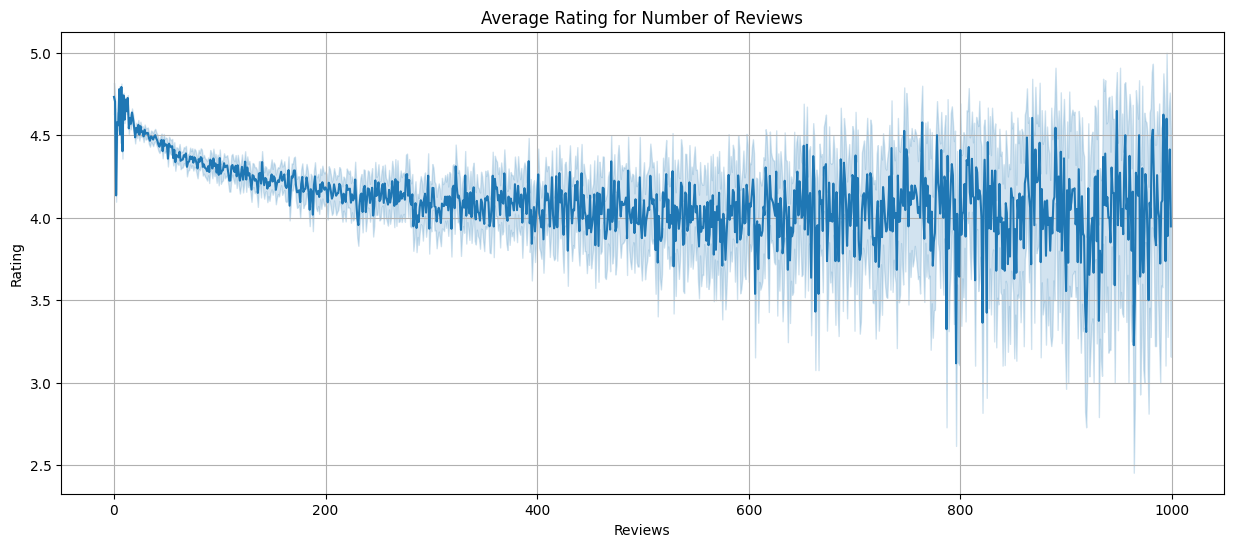

In [40]:
plt.figure(figsize=(15, 6))
sns.lineplot(x="reviewLength", y="rating", data=df[df["reviewLength"] < 1000])
plt.title('Average Rating for Number of Reviews')
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

In [41]:
print("Percentage of reviews coverd by reviews length of 100:", len(df[df["reviewLength"] < 100])/len(df.dropna(subset="reviewLength")) * 100)
print("Percentage of reviews coverd by reviews length of 200:", len(df[df["reviewLength"] < 200])/len(df.dropna(subset="reviewLength")) * 100)
print("Percentage of reviews coverd by reviews length of 400:", len(df[df["reviewLength"] < 400])/len(df.dropna(subset="reviewLength")) * 100)
print("Percentage of reviews coverd by reviews length of 600:", len(df[df["reviewLength"] < 600])/len(df.dropna(subset="reviewLength")) * 100)
print("Percentage of reviews coverd by reviews length of 800:", len(df[df["reviewLength"] < 800])/len(df.dropna(subset="reviewLength")) * 100)
print("Percentage of reviews coverd by reviews length of 1000:", len(df[df["reviewLength"] < 1000])/len(df.dropna(subset="reviewLength")) * 100)

Percentage of reviews coverd by reviews length of 100: 56.973310225303294
Percentage of reviews coverd by reviews length of 200: 76.26620450606586
Percentage of reviews coverd by reviews length of 400: 90.53330032186184
Percentage of reviews coverd by reviews length of 600: 95.35786085664768
Percentage of reviews coverd by reviews length of 800: 97.42134191631592
Percentage of reviews coverd by reviews length of 1000: 98.43466204506066


The graph shows that up to review length of 200 the trend is narrow and the average rating drops down as length grows, but after review length of 200 the average rating score stays more stable despite high volatility of the reviews. The volatility might be explaind by lower number of long reviews (less dense data)

In [42]:
df["descLength"] = df["description"].str.len()

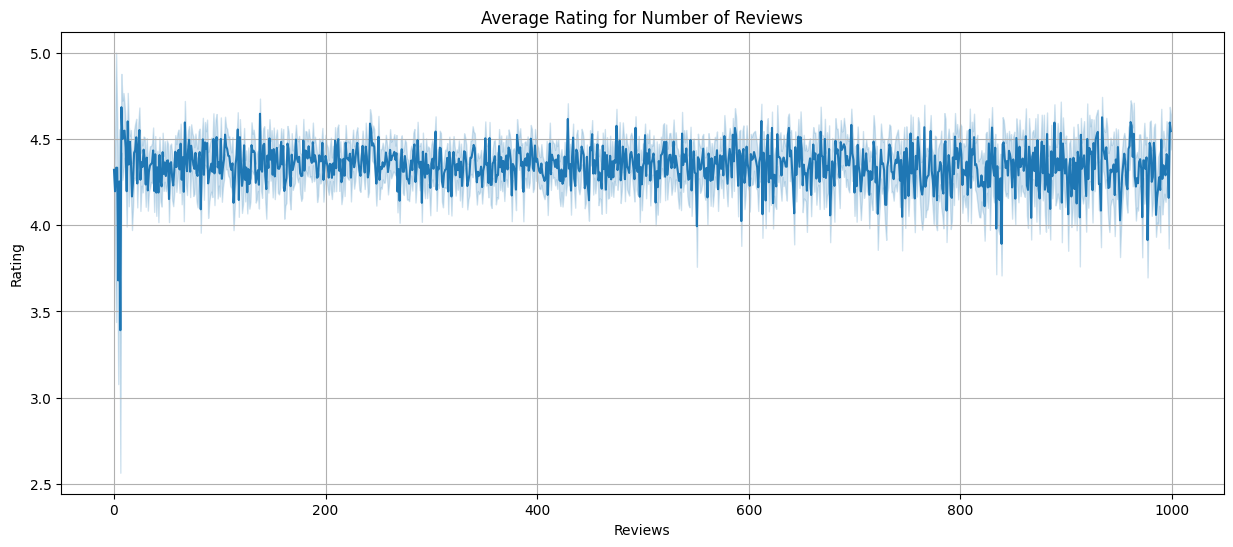

In [43]:
plt.figure(figsize=(15, 6))
sns.lineplot(x="descLength", y="rating", data=df[df["descLength"] < 1000])
plt.title('Average Rating for Number of Reviews')
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

The item description length does not have significant impact on the average rating, although there is a negative peak next to the beggining of the x-axis (I assume this can be explained by low nomber of such short descriptions)